# Lab3 – Data Engineering & EDA with Python, SQL, and Pandas

**Coursework goal:** practice hands-on data engineering by generating synthetic employee data, storing it in a free cloud Postgres database (Neon), loading it with Python, and performing EDA + visualizations.

> ✅ **Important:** You must create a free Neon Postgres database and paste your connection details in the **Environment Variables** cell below.  
> This notebook is written so you can run it end-to-end after you set those variables.


## 0. Setup

This notebook uses:
- **Neon Postgres** (cloud database)
- **psycopg2** for connecting + inserting
- **Pandas** for data wrangling
- **Faker** for synthetic records
- **Matplotlib** for visualizations
- **scikit-learn** for scaling

Run the install cell once (or ensure these are already installed in your environment).


In [13]:
# If needed, install dependencies (uncomment if running in a fresh environment)
# !pip install pandas psycopg2-binary faker matplotlib scikit-learn python-dotenv

import os
import random
import datetime
from datetime import date

import pandas as pd
import numpy as np

import psycopg2
from psycopg2.extras import execute_values

from faker import Faker

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## 1. Data Collection & Database Connection

### 1.1 Create a free Neon database
1. Go to Neon.tech → create a free project
2. Copy your connection info (host, database, user, password, port)
3. Set environment variables below (recommended), or paste them directly.

**Why environment variables?**  
It prevents accidentally committing credentials into GitHub.


In [14]:
NEON_HOST = "ep-wispy-mountain-aijldqct-pooler.c-4.us-east-1.aws.neon.tech"
NEON_DB = "workshop"
NEON_USER = "neondb_owner"
NEON_PASSWORD = "npg_c74uqSvUsyPR"
NEON_PORT = 5432

CONN_INFO = dict(
    host=NEON_HOST,
    dbname=NEON_DB,
    user=NEON_USER,
    password=NEON_PASSWORD,
    port=NEON_PORT,
    sslmode="require",  # Neon typically requires SSL
)

CONN_INFO


{'host': 'ep-wispy-mountain-aijldqct-pooler.c-4.us-east-1.aws.neon.tech',
 'dbname': 'workshop',
 'user': 'neondb_owner',
 'password': 'npg_c74uqSvUsyPR',
 'port': 5432,
 'sslmode': 'require'}

### 1.2 Connect to Postgres (Neon)

We connect using `psycopg2`, then use SQL to create the required table(s).


In [15]:
def get_conn():
    return psycopg2.connect(**CONN_INFO)

# quick connection test
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT NOW();")
        print("Connected. Server time:", cur.fetchone()[0])

Connected. Server time: 2026-02-06 14:33:42.744738+00:00


### 1.3 Create tables

Required table: **employees**

We also create a **departments** table to support the *advanced visualization challenge* (join + more complex dataset).


In [16]:
def create_tables():
    EMPLOYEES_DDL = '''
    CREATE TABLE IF NOT EXISTS employees (
        employee_id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        position TEXT NOT NULL,
        start_date DATE NOT NULL,
        salary INTEGER NOT NULL CHECK (salary BETWEEN 60000 AND 200000)
    );
    '''

    # second table for part 3
    DEPARTMENTS_DDL = '''
    CREATE TABLE IF NOT EXISTS departments (
        department_id SERIAL PRIMARY KEY,
        department_name TEXT NOT NULL,
        location TEXT NOT NULL,
        annual_budget INTEGER NOT NULL CHECK (annual_budget BETWEEN 200000 AND 5000000)
    );
    '''

    # relationship table (employee belongs to a department)
    EMP_DEPT_DDL = '''
    CREATE TABLE IF NOT EXISTS employee_departments (
        employee_id INTEGER PRIMARY KEY REFERENCES employees(employee_id) ON DELETE CASCADE,
        department_id INTEGER NOT NULL REFERENCES departments(department_id) ON DELETE CASCADE
    );
    '''

    with get_conn() as conn:
        with conn.cursor() as cur:
            cur.execute(EMPLOYEES_DDL)
            cur.execute(DEPARTMENTS_DDL)
            cur.execute(EMP_DEPT_DDL)
        conn.commit()

    print("Tables ensured: employees, departments, employee_departments")


### 1.4 Generate & populate synthetic records (≥ 50)

We generate **at least 500 employees** using Faker:
- IT-related positions
- start_date between 2015 and 2024
- salary between 60k and 200k

Then we insert into Neon Postgres.


In [17]:
fake = Faker()

POSITIONS = [
    "Data Engineer",
    "Data Analyst",
    "ML Engineer",
    "Cloud Engineer",
    "DevOps Engineer",
    "Backend Developer",
    "Full Stack Developer",
    "Database Administrator",
    "Cybersecurity Analyst",
    "QA Automation Engineer",
]

DEPT_SEED = [
    ("Data Platform", "Toronto, ON"),
    ("Cloud Infrastructure", "Waterloo, ON"),
    ("Security", "Ottawa, ON"),
    ("Product Engineering", "Mississauga, ON"),
    ("Analytics", "Montreal, QC"),
]

# add a 10% chance of generating an out-of-bounds date or salary
# add a 10% chance of generating an wrong date
def one_in_ten():
    return random.random() < 0.1


def random_date_2015_2024():
    # Faker date_between with explicit bounds
    if(one_in_ten()):
        return date(2014, 1, 1)
    else:
        return fake.date_between(
            start_date=datetime.date(2015, 1, 1),
            end_date=datetime.date(2024, 12, 31)
        )


def gen_employees(n=800, start_id=1001):
    records = []
    for i in range(n):
        emp_id = start_id + i
        name = fake.name()
        position = random.choice(POSITIONS)
        start_date = random_date_2015_2024()
        if(one_in_ten()):
            salary = random.randint(50000, 59999)
        else:
            salary = random.randint(60000, 200000)
        records.append((emp_id, name, position, start_date, salary))
    return records

def gen_departments():
    rows = []
    for dept_name, loc in DEPT_SEED:
        budget = random.randint(300000, 4000000)
        rows.append((dept_name, loc, budget))
    return rows

# employees_rows = gen_employees(n=80, start_id=1001)  # >= 50
# departments_rows = gen_departments()

# len(employees_rows), len(departments_rows), employees_rows[0]


def count_tables(cur):
    tables = ["employees", "departments", "employee_departments"]
    counts = {}
    for table in tables:
        cur.execute(f"SELECT COUNT(*) FROM {table};")
        counts[table] = cur.fetchone()[0]
        print(f"Table {table} has {counts[table]} rows.")
    return counts

#### Insert into database

To make re-runs easy, we:
- **TRUNCATE** (clear) tables first
- Insert fresh synthetic data


In [18]:
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT COUNT(*) FROM employees;")
        emp_count = cur.fetchone()[0]

        if emp_count == 0:
            print("Employees table empty → inserting data...")

            # Clear all tables first
            cur.execute("""
            TRUNCATE TABLE employee_departments, employees, departments
            RESTART IDENTITY;
            """)

            employees_rows = gen_employees(n=800, start_id=1001)  # >= 500
            departments_rows = gen_departments()

            print(len(employees_rows), len(departments_rows), employees_rows[0])

            # Insert departments
            execute_values(
                cur,
                "INSERT INTO departments (department_name, location, annual_budget) VALUES %s",
                departments_rows,
            )

            # Insert employees
            execute_values(
                cur,
                "INSERT INTO employees (employee_id, name, position, start_date, salary) VALUES %s",
                employees_rows,
            )

            # Assign each employee to a department (random mapping)
            cur.execute("SELECT department_id FROM departments;")
            dept_ids = [r[0] for r in cur.fetchall()]
            emp_dept_rows = [(emp_id, random.choice(dept_ids)) for (emp_id, *_rest) in employees_rows]

            execute_values(
                cur,
                "INSERT INTO employee_departments (employee_id, department_id) VALUES %s",
                emp_dept_rows,
            )
            conn.commit()
            print("Inserted:", len(employees_rows), "employees,", len(departments_rows), "departments, and employee_department mappings.")
        else:
            print("Skipping insertion.")
            count_tables(cur)

Employees table empty → inserting data...
800 5 (1001, 'Rita Phillips', 'Backend Developer', datetime.date(2024, 7, 21), 199280)
Inserted: 800 employees, 5 departments, and employee_department mappings.


### 1.5 Query and load data into a Pandas DataFrame

We query the entire employee table and display `df.head()` as required.


In [19]:

with get_conn() as conn:
    df_emp = pd.read_sql("SELECT * FROM employees ORDER BY employee_id;", conn)

df_emp.head()


C:\Users\85155\AppData\Local\Temp\ipykernel_34452\4237117105.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_emp = pd.read_sql("SELECT * FROM employees ORDER BY employee_id;", conn)


,employee_id,name,position,start_date,salary
0,1001,Rita Phillips,Backend Developer,2024-07-21,199280
1,1002,Emily Ortiz,Full Stack Developer,2022-03-22,106754
2,1003,Samuel Edwards,ML Engineer,2017-08-14,56580
3,1004,Steven Horne,Cybersecurity Analyst,2016-02-18,75365
4,1005,Robert Sandoval,Backend Developer,2020-03-07,184729


## 2. Exploratory Data Analysis (EDA)

In this section we demonstrate:
- **Descriptive statistics**: `.info()`, `.describe()`
- **Missing values**: `.isnull().sum()`
- Basic sanity checks (salary range, date range)


In [20]:
df_emp.info()


<class 'pandas.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  800 non-null    int64 
 1   name         800 non-null    str   
 2   position     800 non-null    str   
 3   start_date   800 non-null    object
 4   salary       800 non-null    int64 
dtypes: int64(2), object(1), str(2)
memory usage: 31.4+ KB


In [21]:
df_emp.describe(include="all")


,employee_id,name,position,start_date,salary
count,800.0000,800,800,800,800.000000
unique,NaN,798,10,647,NaN
top,NaN,Ashley Morgan,Data Engineer,2014-01-01,NaN
freq,NaN,2,91,78,NaN
mean,1400.5000,NaN,NaN,NaN,121227.343750
std,231.0844,NaN,NaN,NaN,42907.335684
min,1001.0000,NaN,NaN,NaN,50064.000000
25%,1200.7500,NaN,NaN,NaN,85052.500000
50%,1400.5000,NaN,NaN,NaN,119743.500000
75%,1600.2500,NaN,NaN,NaN,158220.750000


In [22]:
df_emp.isnull().sum()


employee_id    0
name           0
position       0
start_date     0
salary         0
dtype: int64

## 3. Data Cleaning

Because the data is synthetic, we expect no missing values, but we still **check and enforce**:
- salary within **[60k, 200k]**
- start_date between **2015-01-01** and **2024-12-31**
- normalize position names (trim spaces, consistent casing)


In [23]:
# Ensure correct dtypes
df_emp["start_date"] = pd.to_datetime(df_emp["start_date"])

# Normalize positions
df_emp["position"] = df_emp["position"].astype(str).str.strip()

# Sanity checks
salary_outside = df_emp[(df_emp["salary"] < 60000) | (df_emp["salary"] > 200000)]
date_outside = df_emp[(df_emp["start_date"] < "2015-01-01") | (df_emp["start_date"] > "2024-12-31")]

salary_outside.shape, date_outside.shape


((72, 5), (78, 5))

## 4. Data Transformation & Feature Engineering

We add:
- `start_year`: extracted from start_date
- `years_of_service`: years from start_date to a reference date (today)

These are useful for grouping, trends, and tenure-based analysis.


In [24]:
today = pd.Timestamp(date.today())

df_emp["start_year"] = df_emp["start_date"].dt.year
df_emp["years_of_service"] = ((today - df_emp["start_date"]).dt.days / 365.25).round(2)

df_emp[["employee_id", "position", "start_date", "start_year", "years_of_service", "salary"]].head()


,employee_id,position,start_date,start_year,years_of_service,salary
0,1001,Backend Developer,2024-07-21,2024,1.55,199280
1,1002,Full Stack Developer,2022-03-22,2022,3.88,106754
2,1003,ML Engineer,2017-08-14,2017,8.48,56580
3,1004,Cybersecurity Analyst,2016-02-18,2016,9.97,75365
4,1005,Backend Developer,2020-03-07,2020,5.92,184729


## 5. Scaling

We apply scaling to numeric columns to prepare data for modeling and to compare features on a similar scale.

Here we scale:
- `salary`
- `years_of_service`

We demonstrate **MinMaxScaler** (0 to 1). (StandardScaler is also valid.)


In [25]:
scaler = MinMaxScaler()
df_scaled = df_emp.copy()

df_scaled[["salary_scaled", "years_scaled"]] = scaler.fit_transform(df_emp[["salary", "years_of_service"]])

df_scaled[["salary", "salary_scaled", "years_of_service", "years_scaled"]].head()


,salary,salary_scaled,years_of_service,years_scaled
0,199280,0.997013,1.55,0.040036
1,106754,0.378784,3.88,0.252047
2,56580,0.043538,8.48,0.670610
3,75365,0.169053,9.97,0.806187
4,184729,0.899788,5.92,0.437671


## 6. Standard Visualization: Average Salary by Position and Start Year

**Goal:** grouped bar chart showing the **average salary** by:
- `position`
- `start_year`

This matches the class-style visualization requirement.


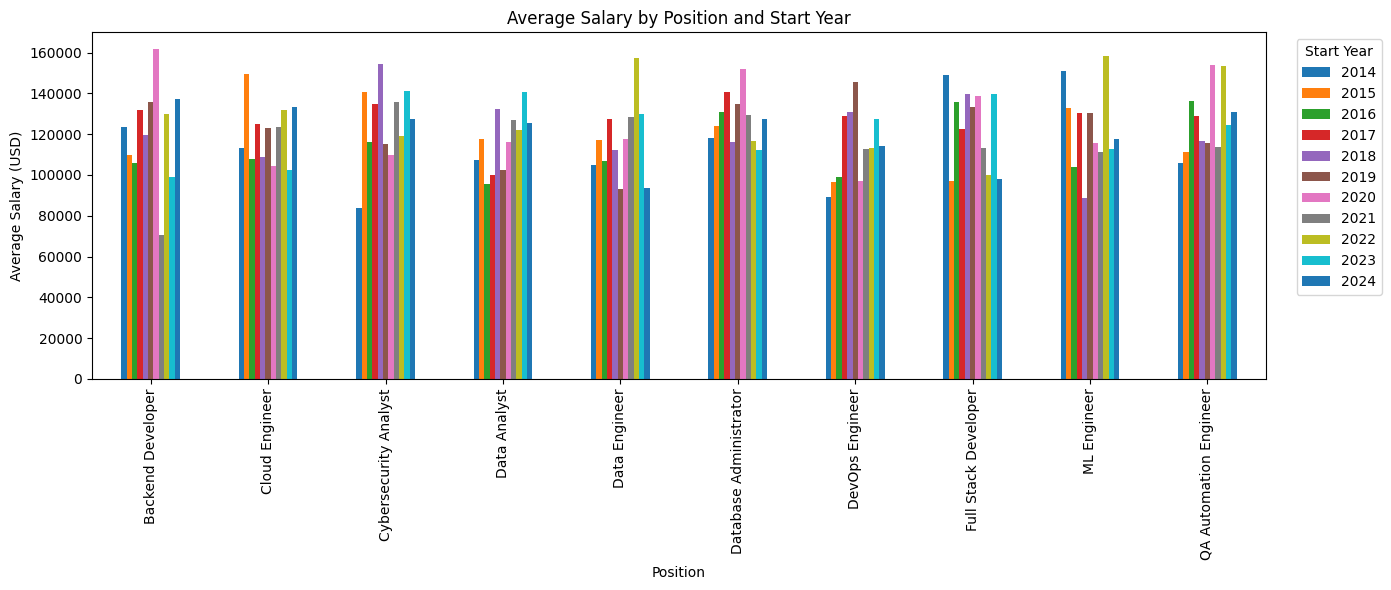

In [26]:
# Pivot for grouped bar chart
pivot = (
    df_emp
    .groupby(["position", "start_year"])["salary"]
    .mean()
    .reset_index()
    .pivot(index="position", columns="start_year", values="salary")
    .fillna(0)
)

ax = pivot.plot(kind="bar", figsize=(14, 6))
ax.set_title("Average Salary by Position and Start Year")
ax.set_xlabel("Position")
ax.set_ylabel("Average Salary (USD)")
ax.legend(title="Start Year", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Findings

- Observation 1: ML Engineer, QA Automation Engineer, and Full Stack Developer generally show higher average salaries compared to other roles across multiple years.

- Observation 2: Some years (such as 2022 and 2023) appear to have noticeably higher salary averages for several positions, which may reflect overall upward salary trends or random variation in the synthetic data.

- Observation 3: There is a gradual increase in average salary over time for many positions, suggesting a possible growth trend in compensation levels across start years.


## 7. Advanced Visualization: Join with Departments + Heatmap

### 7.1 Build a more complex dataset (SQL join)
We join:
- employees
- employee_departments
- departments

Then visualize **average salary** by:
- department_name
- position

We use a **heatmap** (matplotlib `imshow`) to satisfy the advanced visualization requirement.


In [ ]:
with get_conn() as conn:
    # Create a "project assignment" table and analyze distribution of salaries or years of service by project or department.
    df_project_assignment = pd.read_sql(
        '''
        SELECT 
            e.employee_id,
            e.name,
            e.position,
            e.start_date,
            e.salary,
            d.department_name,
            d.location,
            d.annual_budget
        FROM employees e
        JOIN employee_departments ed ON e.employee_id = ed.employee_id
        JOIN departments d ON ed.department_id = d.department_id
        ORDER BY e.employee_id;
        ''',
        conn
    )

df_project_assignment["start_date"] = pd.to_datetime(df_project_assignment["start_date"])
df_project_assignment["start_year"] = df_project_assignment["start_date"].dt.year
df_project_assignment["years_of_service"] = (
    (pd.Timestamp.today() - df_project_assignment["start_date"]).dt.days / 365.25
).round(2)

df_project_assignment.head()


C:\Users\85155\AppData\Local\Temp\ipykernel_34452\3853502814.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_project_assignment = pd.read_sql(


,employee_id,name,position,start_date,salary,department_name,location,annual_budget,start_year,years_of_service
0,1001,Rita Phillips,Backend Developer,2024-07-21,199280,Data Platform,"Toronto, ON",2243071,2024,1.55
1,1002,Emily Ortiz,Full Stack Developer,2022-03-22,106754,Cloud Infrastructure,"Waterloo, ON",3492243,2022,3.88
2,1003,Samuel Edwards,ML Engineer,2017-08-14,56580,Data Platform,"Toronto, ON",2243071,2017,8.49
3,1004,Steven Horne,Cybersecurity Analyst,2016-02-18,75365,Analytics,"Montreal, QC",1761156,2016,9.98
4,1005,Robert Sandoval,Backend Developer,2020-03-07,184729,Cloud Infrastructure,"Waterloo, ON",3492243,2020,5.92


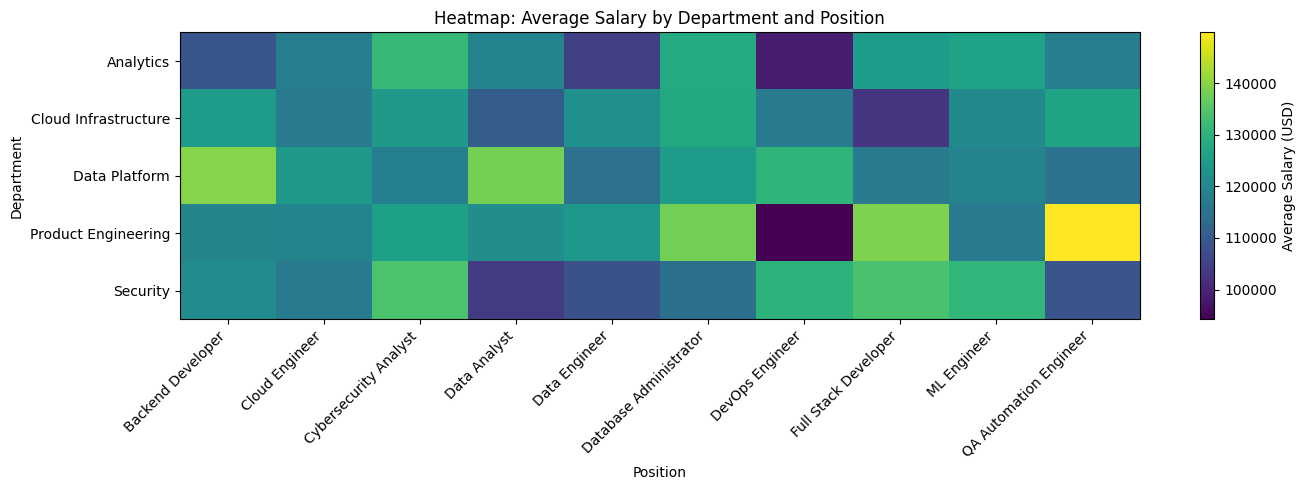

In [28]:

# Create a table of avg salary by department and position
heat = (
    df_project_assignment
    .groupby(["department_name", "position"])["salary"]
    .mean()
    .reset_index()
    .pivot(index="department_name", columns="position", values="salary")
)

# Heatmap with imshow (no seaborn)
fig, ax = plt.subplots(figsize=(14, 5))
im = ax.imshow(heat.values, aspect="auto")

ax.set_title("Heatmap: Average Salary by Department and Position")
ax.set_xlabel("Position")
ax.set_ylabel("Department")

ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels(heat.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Average Salary (USD)")

plt.tight_layout()
plt.show()


### Findings

- Observation 1: Product Engineering shows some of the highest average salaries across multiple positions, particularly for QA Automation Engineer and Database Administrator.

- Observation 2: Data Platform also appears relatively strong across several technical roles, such as Backend Developer and Data Analyst, suggesting generally higher compensation levels in that department.

- Observation 3: There are noticeable variations within certain department–position combinations (for example, DevOps Engineer in Product Engineering appears significantly lower than other roles), which may be due to random variation in the synthetic dataset.


## 8. Insights & Conclusions

Summarize what you learned:
- connecting Python ↔ cloud Postgres
- generating + inserting data
- cleaning / transformation / feature engineering
- scaling
- building visualizations and extracting insights

**Example outline:**
- What worked smoothly?
- What was tricky?
- What you would improve if this were real HR data?
